# Previously opening emails predicts opening more emails

In [1]:
import numpy as np
import pandas as pd

In [2]:
data = pd.read_csv("../data_snippet.csv") # Load data snippet

In [3]:
data.head()

,riid,opened,rev_3dv2,unsub,campaign_type,retention_score,recency_score,frequency_score
0,242697842,1,75.00,0,Dedicated,14.000000,1.637422,31
1,275469002,1,75.00,0,Dedicated,2.800000,0.000000,0
2,4319542,1,19.98,0,Dedicated,1.000000,0.084239,4
3,166170102,1,19.98,0,Dedicated,0.756757,0.010870,1
4,6998482,1,150.00,0,Dedicated,28.000000,1.845885,18


In [4]:
customers = {} # create customer data dictionary, where key = customer id,
               # value = list of tuples (opened, revenue, unsubscribed) for all emails to that customer

for index, row in data.iterrows():
    if row['riid'] not in customers.keys():
        customers[row['riid']] = []
    customers[row['riid']].append((row['opened'], row['rev_3dv2'], row['unsub']))

In [5]:
max_emails = 0 # find maximum number of emails that any customer received
i = 0
for key in customers.keys():
    if len(customers[key]) > max_emails:
        max_emails = len(customers[key])
print (max_emails)

51


In [6]:
# Find numbers of the following events:
# --> customer opened email this time, as well as j emails ago (11)
# --> customer opened email this time, but not j emails ago (10)
# --> customer did not open email this time, but did j emails ago (01)
# --> customer didn't open email this time and j emails ago (00)
# for each j value from 1 to max_emails

all_corrs = np.zeros(( max_emails - 1, 2, 2 ))

last_opened = 0 # number of customers who opened the last email
prev_opened = 0 # number of customers who opened the second to last email

for key in customers.keys():
    last_opened += customers[key][0][0]
    if len(customers[key]) != 1: # if customer received only 1 email, no inference based on past behavior possible
        prev_opened += customers[key][1][0]
        for j in range( len(customers[key]) - 1 ): # otherwise, use data to calculate metrics for j emails ago
            all_corrs[j][customers[key][0][0]][customers[key][j+1][0]] += 1

In [7]:
# Find total numbers of unopened (0) and opened (1) emails for each j value
totals = np.zeros((max_emails - 1, 2))
for j in range(len(all_corrs)):
    totals[j] = all_corrs[j].sum(axis=(0))

In [8]:
# Find the expected fractions of opened and unopened emails for last step,
# conditional on the email j emails ago being opened or unopened
for j in range(len(all_corrs)):
    if totals[j][0] > 0:
        all_corrs[j][0] /= totals[j][0]
    else:
        all_corrs[j][0][0] = 0.
        all_corrs[j][0][1] = 0.
    if totals[j][1] > 0:
        all_corrs[j][1] /= totals[j][1]
    else:
        all_corrs[j][1][0] = 0.
        all_corrs[j][1][1] = 0.

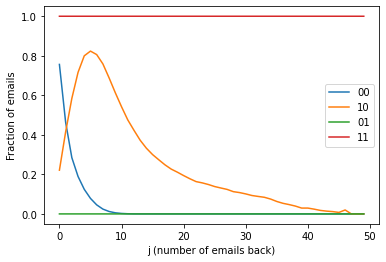

In [9]:
# First number in legend is the state of the current email (0 - unopened, 1 - opened),
# second number is the state for j emails ago 
import matplotlib.pyplot as plt

plt.plot(all_corrs[::,0,0], label='00')
plt.plot(all_corrs[::,1,0], label='10')
plt.plot(all_corrs[::,0,1], label='01')
plt.plot(all_corrs[::,1,1], label='11')
plt.xlabel("j (number of emails back)")
plt.ylabel("Fraction of emails")
plt.legend()

[[7.56233644e-01 2.34852043e-05]
 [2.21266319e-01 9.99978683e-01]]


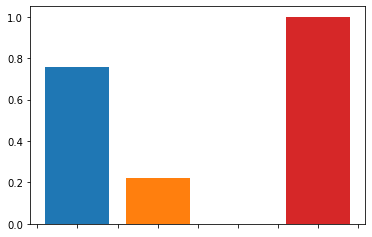

In [10]:
# Data from previous graph for j=1, same colors as above
# If previous email was opened, there is over a 99.99% chance the next one will be opened
plt.figure().add_subplot(111).tick_params(labelbottom=False)
plt.bar(1,all_corrs[0][0][0])
plt.bar(2,all_corrs[0][1][0])
plt.bar(3,all_corrs[0][0][1])
plt.bar(4,all_corrs[0][1][1])

print (all_corrs[0])

In [11]:
total_last1 = all_corrs[0][1][1] + all_corrs[0][0][1]
total_last0 = all_corrs[0][1][0] + all_corrs[0][0][0]
print ("Opened last one:")
print (all_corrs[0][1][1]/total_last1*100)
print (all_corrs[0][0][1]/total_last1*100)
print ("Didn't open last one:")
print (all_corrs[0][1][0]/total_last0*100)
print (all_corrs[0][0][0]/total_last0*100)

Opened last one:
99.9976514846588
0.002348515341196867
Didn't open last one:
22.635941437287084
77.36405856271291
